#### Import wymaganych bibliotek

In [1]:
%matplotlib inline  

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries import offsets

import osmnx as ox
import geopandas as gpd
import maxrect
import cvxpy
from shapely.geometry import Polygon, MultiPolygon, LineString
from shapely.ops import unary_union

from timezonefinder import TimezoneFinder
from datetime import date

from pvlib import solarposition
from pvlib import location
from pvlib import irradiance
from pvlib import iotools

import warnings
warnings.filterwarnings("ignore")

#### Sekcja ustawień

###### Dane geograficzne

In [2]:
west, south, east, north = 18.96429,52.9297,18.986743,52.933942

###### Funkcje pomocnicze

In [3]:
def get_area_data(west, south, east, north):
    
    def _download_footprints(west, south, east, north,footprints_type = 'landuse'):
        polygon = ox.utils_geo.bbox_to_poly(north,south,east,west)
        footprints_gdf = ox.footprints_from_polygon(polygon,footprint_type=footprints_type)
        
        return polygon, footprints_gdf


    def _filter_footprints(footprints_gdf, footprints_type = 'landuse', chosenFootprints = ['farmland','forest','grass','meadow']):
        filtered_gdf = footprints_gdf.loc[footprints_gdf[footprints_type].isin(chosenFootprints)]

        return filtered_gdf

    def _modified_get_maximal_rectangle(coordinates):

        """
        Find the largest, inscribed, axis-aligned rectangle.
        :param coordinates:
            A list of of [x, y] pairs describing a closed, convex polygon.
        """

        coordinates = np.array(coordinates)
        x_range = np.max(coordinates, axis=0)[0]-np.min(coordinates, axis=0)[0]
        y_range = np.max(coordinates, axis=0)[1]-np.min(coordinates, axis=0)[1]

        scale = np.array([x_range, y_range])
        sc_coordinates = coordinates/scale

        poly = Polygon(sc_coordinates)
        inside_pt = (poly.representative_point().x,
                     poly.representative_point().y)

        A1, A2, B = maxrect.pts_to_leq(sc_coordinates)

        bl = cvxpy.Variable(2)
        tr = cvxpy.Variable(2)
        br = cvxpy.Variable(2)
        tl = cvxpy.Variable(2)
        obj = cvxpy.Maximize(cvxpy.log(tr[0] - bl[0]) + cvxpy.log(tr[1] - bl[1]))
        constraints = [bl[0] == tl[0],
                       br[0] == tr[0],
                       tl[1] == tr[1],
                       bl[1] == br[1],
                       ]

        for i in range(len(B)):
            if inside_pt[0] * A1[i] + inside_pt[1] * A2[i] <= B[i]:
                constraints.append(bl[0] * A1[i] + bl[1] * A2[i] <= B[i])
                constraints.append(tr[0] * A1[i] + tr[1] * A2[i] <= B[i])
                constraints.append(br[0] * A1[i] + br[1] * A2[i] <= B[i])
                constraints.append(tl[0] * A1[i] + tl[1] * A2[i] <= B[i])

            else:
                constraints.append(bl[0] * A1[i] + bl[1] * A2[i] >= B[i])
                constraints.append(tr[0] * A1[i] + tr[1] * A2[i] >= B[i])
                constraints.append(br[0] * A1[i] + br[1] * A2[i] >= B[i])
                constraints.append(tl[0] * A1[i] + tl[1] * A2[i] >= B[i])

        prob = cvxpy.Problem(obj, constraints)

        try:
            solver='ECOS'
            prob.solve(solver=solver, verbose=False)
        except:
            try:
                solver='ECOS_BB'
                prob.solve(solver=solver, verbose=False)
            except:
                try:
                    solver='CVXOPT'
                    prob.solve(solver=solver, verbose=False)
                except:
                    try:
                        solver='OSQP'
                        prob.solve(solver=solver, verbose=False)
                    except:
                        try:
                            solver='GLPK'
                            prob.solve(solver=solver, verbose=False)   
                        except:
                            try:
                                solver='GLPK_MI'
                                prob.solve(solver=solver, verbose=False)  
                            except:
                                solver='SCS'
                                prob.solve(solver=solver, verbose=False)  

        bottom_left = np.array(bl.value).T * scale
        top_right = np.array(tr.value).T * scale

        return list(bottom_left), list(top_right)

    def _fit_plot_ranctangle_polygon(polygon):
        coordinates = list(polygon.exterior.coords)
        ll, ur = maxrect.get_maximal_rectangle(coordinates)
        calculated_coordinates = maxrect.rect2poly(ll,ur)

        poly_coordinates = Polygon(coordinates)
        poly_calculated = Polygon(calculated_coordinates)

        return poly_calculated
    

    poly, footprints_landuse_gdf = _download_footprints(west,south,east,north)
    filtered_footprints_landuse_gdf = _filter_footprints(footprints_landuse_gdf)
    landuse_bbox = filtered_footprints_landuse_gdf['geometry'].intersection(poly)
    landuse_bbox_gdf = gpd.GeoDataFrame(geometry=landuse_bbox)
    landuse_bbox_gdf = landuse_bbox_gdf[landuse_bbox_gdf.is_empty == False]
    area_polygon = landuse_bbox_gdf.unary_union

    if isinstance(area_polygon, MultiPolygon):
        biggest_poly = 0
        multipoly = area_polygon
        for poly in list(multipoly):
            if(poly.area > biggest_poly):
                new_area_polygon = poly
                biggest_poly = poly.area
        area_polygon = new_area_polygon

    area_convexhull_polygon = area_polygon.convex_hull
    area_polygon_utm, crs_utm = ox.projection.project_geometry(area_polygon)
    area_convexhull_polygon_utm, crs_utm = ox.projection.project_geometry(area_convexhull_polygon)

    #monkey patch function
    maxrect.get_maximal_rectangle = _modified_get_maximal_rectangle
    convexhull_poly_calculated = _fit_plot_ranctangle_polygon(area_convexhull_polygon_utm)

    x_coord_list = []
    y_coord_list = []

    for x,y in convexhull_poly_calculated.exterior.coords:
        x_coord_list.append(x)
        y_coord_list.append(y)

    x = math.ceil(max(x_coord_list) - min(x_coord_list)) 
    y = math.ceil(max(y_coord_list) - min(y_coord_list))
    
    return x,y


In [4]:
def get_lat_lon(west, south, east, north):
    lon = (west + east)/2
    lat = (south+north)/2
    
    return lat, lon

In [5]:
def get_weather_df(data):
    weather_data = data
    weather_data['time[UTC]'] = weather_data.index
    weather_data = weather_data.assign(time_temp = weather_data['time[UTC]'].apply(lambda x: x.replace(year=currentYear)))
    weather_data['time_local'] = weather_data['time_temp'].dt.tz_convert(tz)
    weather_data.index = weather_data['time_local']
    weather_data.drop(['time[UTC]','time_temp','time_local'], axis=1, inplace=True)

    times_df = pd.DataFrame(index=times)
    weather = times_df.join(weather_data, how='left')
    weather.fillna(0,inplace=True)

    weather = weather[['G(h)','Gb(n)','Gd(h)','T2m','WS10m','SP']]
    weather.columns = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed','pressure']
    
    return weather

In [6]:
def size_system(module_tilt, module_width, module_length, elevation_angle, area_x, area_y):
    b = module_tilt
    L = module_length
    z = module_width
    a = elevation_angle
    x = area_x
    y = area_y
    
    D = (L*np.sin(np.deg2rad(180-a-b)))/np.sin(np.deg2rad(a))
    Lx = L * np.cos(np.deg2rad(b))
    Ly= L * np.sin(np.deg2rad(b))
    Dr = round(D - Lx,2)

    x_a = x - 10
    n_x = int(x_a / z)
    y_a = y - 10
    n_y = int((y_a + Dr)/ D)

    n_max = n_x * n_y

    Ui_avg = (Ui_mpp_min + Ui_mpp_max)/2
    n_s = math.floor(Ui_avg/Um_mpp)
   
    while(n_s*Um_oc > Ui_dc):
        n_s = n_s - 1

    n_r = math.floor(Ii_dc/Im_mpp)
    n_i = math.ceil(n_max/(n_s*n_r))
        
    while(n_s*n_r*n_i>n_max):
        n_i = n_i-1

    n_pv = n_s*n_r*n_i

    P_c = n_pv * P_n
    
    return P_c, n_pv, n_s, n_r, n_i

#### Wyznaczenie dostępnego terenu 

In [7]:
x,y = get_area_data(west, south, east, north)
lat,lon = get_lat_lon(west, south, east, north)

#### Modelowanie i symulacja pracy instalacji

In [8]:
tf = TimezoneFinder()
tz = tf.timezone_at(lng=lon, lat=lat)
currentYear = date.today().year
yearStart= date.today() - offsets.YearBegin()
yearEnd = yearStart.replace(year = yearStart.year + 1)

times = pd.date_range(yearStart,yearEnd, closed='left',freq='H', tz=tz)

data, months_selected, inputs, meta = iotools.get_pvgis_tmy(lat,lon)
altitude = inputs['location']['elevation']
weather = get_weather_df(data)

solpos = solarposition.get_solarposition(times,lat,lon,altitude,pressure=weather['pressure'],temperature=weather['temp_air'])
solpos_elevation = solpos[['elevation']]
solpos_elevation = solpos_elevation.assign(date = pd.to_datetime(solpos_elevation.index.date))
solar_noons = solpos_elevation.groupby(['date'])['elevation'].max().reset_index()
solar_noon_min = solar_noons[solar_noons['elevation'] == min(solar_noons['elevation'])]

a = float(solar_noon_min['elevation']) #kąt padania promieni słonecznych w południe słoneczne podczas przesilenia zimowego [deg]
b = round(abs(lat)) #początkowa wartość kąta pochylenia modułów słonecznych [deg]
azimuth = 180 if lat>=0 else 0

In [9]:
import pvlib
from pvlib import pvsystem
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [10]:
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

sandia_module = sandia_modules['SunPower_SPR_230_WHT__2007__E__']
cec_module = cec_modules['SunPower_SPR_230_WHT_U'] #CEC Database zawiera informacje o wymiarach modułów
cec_inverter = cec_inverters['KACO__KACO_blueplanet_2200_TL3_M1_GM_OD_USX0']

###### Parametry systemu

Parametry modułu PV

In [11]:
z = cec_module.Width #szerokość modułu [m]
L = cec_module.Length #długość modułu [m]
Um_mpp = sandia_module.Vmpo #maximum MPP voltage at STC [V]
Im_mpp = sandia_module.Impo #maximum MPP current at STC [A]
P_n = Um_mpp * Im_mpp #peak power at STC [Wp]
Um_oc = sandia_module.Voco #open circuit voltage at STC [V]

Parametry inwertera

In [12]:
Ui_dc = cec_inverter.Vdcmax #maximum input voltage [V]
Ui_mpp_max = cec_inverter.Mppt_high #DC input maximum MPP voltage [V]
Ui_mpp_min = cec_inverter.Mppt_low #DC input minimum MPP voltage [V]
Ii_dc = cec_inverter.Idcmax #maximum input current [A]
P_i_nom = cec_inverter.Paco

In [13]:
#Energy Availability Factor
EAF = 0.995

In [14]:
def get_daily_production(tilt):
    P_c, n_pv, n_s, n_r, n_i = size_system(module_tilt=tilt,
                                           module_width=z,
                                           module_length=L,
                                           elevation_angle=a,
                                           area_x=x,
                                           area_y=y)
        
    system = PVSystem(surface_tilt=tilt, 
                  surface_azimuth=azimuth,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter,
                  temperature_model_parameters=temperature_model_parameters,
                  modules_per_string=n_s, 
                  strings_per_inverter=n_r)
 
    location = Location(latitude=lat,
                        longitude=lon,
                        tz=tz,
                        altitude=altitude)
    
    mc = ModelChain(system, location)
    mc.run_model(weather)
        
    poa_global = mc.total_irrad.poa_global
    effective_irr = mc.effective_irradiance

    cell_temp = mc.cell_temperature
    aoi = mc.aoi
    aoi_modifier = mc.aoi_modifier
    p_mp = mc.dc.p_mp
    ac_output = mc.ac
    
    system_size = [n_i, n_pv, P_c]
    model_objects = [system,mc]

    result_tbl = pd.DataFrame({
        'POA Glob' : poa_global,
        'Effective Irr' : effective_irr,
        'Cell temp' : cell_temp,
        'AOI' : aoi,
        'Module P at MPP' : p_mp,
        'AC Output inverter' : ac_output,
        'AC Output system' : ac_output * n_i,
        'Energy Output' : ac_output * n_i * EAF
    })
        
    return result_tbl, system_size, model_objects

In [15]:
tilt_lower_bound = 0
tilt_upper_bound = 91

tilt_list = []
power_output_list = []
power_installed_list = []
npv_list = []
ni_list = []
ratio_list = []
system_object_list = []
model_object_list = []

for tilt in range(tilt_lower_bound, tilt_upper_bound):
    
    temp_tbl, system_size, model_objects = get_daily_production(tilt)
    
    p_out = round(temp_tbl['Energy Output'].sum()/1000000,2)
    p_max = round(system_size[2]/1000000,2)
    npv = system_size[1]
    ni = system_size[0]
    ratio = p_out/npv
    system = model_objects[0]
    modelchain = model_objects[1]
    
    tilt_list.append(tilt)
    power_output_list.append(p_out)
    power_installed_list.append(p_max)
    npv_list.append(npv)
    ni_list.append(ni)
    ratio_list.append(p_out/npv)
    system_object_list.append(system)
    model_object_list.append(modelchain)
            
    if(not ratio_list):
        output_tbl = temp_tbl
    elif (ratio == max(ratio_list)):
        output_tbl = temp_tbl
        optimal_tilt = tilt

compare_tbl = pd.DataFrame({
    'n_pv' : npv_list,
    'n_i' : ni_list,
    'Installed_power_MW' : power_installed_list,
    'Energy_Output_MWh' : power_output_list,
    'Output_per_module_ratio' : ratio_list,
    'system_obj' : system_object_list,
    'modelchain_obj' : modelchain
})

compare_tbl.index = tilt_list
compare_tbl.index.name = 'Tilt_angle'   
compare_tbl[['n_pv','n_i','Installed_power_MW','Energy_Output_MWh','Output_per_module_ratio']]

,n_pv,n_i,Installed_power_MW,Energy_Output_MWh,Output_per_module_ratio
Tilt_angle,,,,,
0,193536,21,44.52,45247.11,0.233792
1,184320,20,42.40,43511.01,0.236062
2,175104,19,40.28,41724.12,0.238282
3,156672,17,36.04,37671.56,0.240449
4,147456,16,33.92,35767.02,0.242561
...,...,...,...,...,...
86,46080,5,10.60,9815.64,0.213013
87,46080,5,10.60,9694.77,0.210390
88,46080,5,10.60,9571.89,0.207723


In [16]:
n_pv_opt = int(compare_tbl.loc[optimal_tilt]['n_pv'])
n_i_opt = int(compare_tbl.loc[optimal_tilt]['n_i'])
P_installed_opt_MW = compare_tbl.loc[optimal_tilt]['Installed_power_MW']
P_output_MWh_opt = compare_tbl.loc[optimal_tilt]['Energy_Output_MWh']
Power_per_module_ratio_opt = compare_tbl.loc[optimal_tilt]['Output_per_module_ratio']
system_opt = compare_tbl.loc[optimal_tilt]['system_obj']
modelchain_opt = compare_tbl.loc[optimal_tilt]['modelchain_obj']

print("""
Optymalny kąt pochylenia modułu PV (zmaksymalizowanie uzysku energii elektrycznej - output power per module ratio): {0} deg

Ilość modułów PV: {1}
Ilość inwerterów: {2}
Moc zainstalowana: {3} [MW]

Roczna produkcja energii elektrycznej: {4} [MWh]
""".format(optimal_tilt,n_pv_opt,n_i_opt,P_installed_opt_MW,P_output_MWh_opt))

print("""
Instancja PVSystem:

{0}


Instancja ModelChain oraz wykorzystane modele:

{1}
""".format(system_opt,modelchain_opt))


Optymalny kąt pochylenia modułu PV (zmaksymalizowanie uzysku energii elektrycznej - output power per module ratio): 38 deg

Ilość modułów PV: 55296
Ilość inwerterów: 6
Moc zainstalowana: 12.72 [MW]

Roczna produkcja energii elektrycznej: 15370.98 [MWh]


Instancja PVSystem:

PVSystem: 
  name: None
  surface_tilt: 38
  surface_azimuth: 180
  module: None
  inverter: None
  albedo: 0.25
  racking_model: open_rack


Instancja ModelChain oraz wykorzystane modele:

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses



In [17]:
def get_monthly_production(calc_tbl):

    calc_tbl_monthly = calc_tbl.assign(Year_Month = calc_tbl.index.to_period('M'))
    calc_tbl_monthly = calc_tbl_monthly.groupby(['Year_Month'])['Effective Irr','Energy Output'].sum().reset_index()
    calc_tbl_monthly = calc_tbl_monthly.assign(EI_kWh_m2 = round(calc_tbl_monthly['Effective Irr']/1000,2))
    calc_tbl_monthly = calc_tbl_monthly.assign(E_plant_MWh = round(calc_tbl_monthly['Energy Output']/1000000,2))
    calc_tbl_monthly.drop(['Effective Irr','Energy Output'], axis=1, inplace=True)

    return calc_tbl_monthly

def plot_monthly_production(calc_tbl):
    
    calc_tbl_monthly = get_monthly_production(calc_tbl)
    
    labels = calc_tbl_monthly['Year_Month']
    values = calc_tbl_monthly['E_plant_MWh']

    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots(1, 1, figsize = (13, 5))

    rects1 = ax.bar(x, values, width)

    ax.set_title('Energia elektryczna przekazana do sieci w elektrowni o stałym kącie pochylenia modułów PV w granulacji miesięcznej [MWh]')
    ax.set_xticks(x)
    ax.set_xticklabels(labels,rotation=45)
    plt.yticks([])

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    fig.tight_layout()
    plt.margins(y=0.15)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.show()
    
def plot_monthly_radiation(calc_tbl):
    
    calc_tbl_monthly = get_monthly_production(calc_tbl)
    
    time = calc_tbl_monthly.Year_Month.astype(str).tolist()
    POA_val = calc_tbl_monthly.EI_kWh_m2.tolist()
  
    fig, ax = plt.subplots(1, 1, figsize = (13, 5))

    plt.plot(time, POA_val, color='red', marker='o')
    plt.title('Miesięczne napromieniowanie na powierzchnię pochyłą [kWh/m2]', fontsize=14)
    plt.grid(True)

    for i,j in calc_tbl_monthly.EI_kWh_m2.items():
        ax.annotate(str(j), xy=(i, j))

    plt.show()


Roczne napromieniowanie na powierzchnię pochyłą wynosi: 1302.39 [kWh/m2]



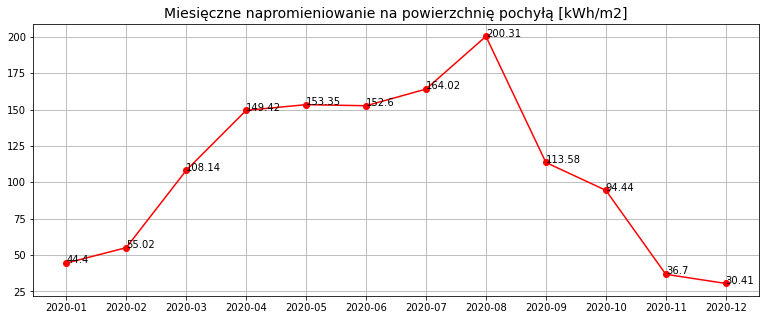

In [18]:
print("\nRoczne napromieniowanie na powierzchnię pochyłą wynosi: {0} [kWh/m2]\n".format(round(get_monthly_production(output_tbl).EI_kWh_m2.sum(),2)))
plot_monthly_radiation(output_tbl)

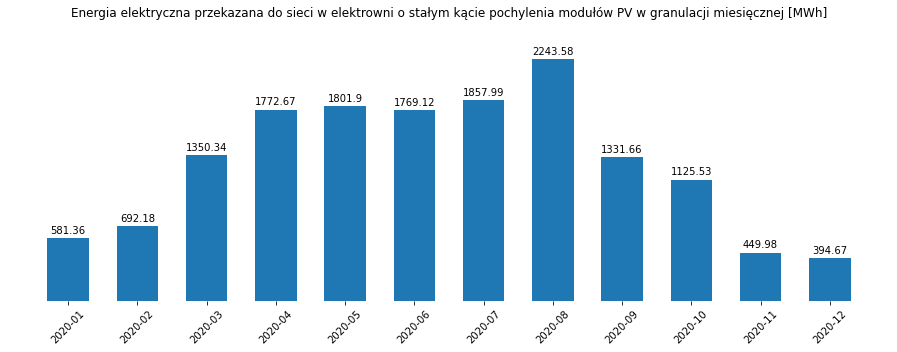

In [19]:
plot_monthly_production(output_tbl)

#### Parametry ewaluacyjne modelu

In [20]:
def performance_analysis(E_yr_kWh,POA_yr_kWh,P_c_kWp):
    
    Yf = E_yr_kWh/P_c_kWp
    PR = E_yr_kWh/(POA_yr_kWh*P_c_kWp)
    CUF = E_yr_kWh / (P_c_kWp * 8760)
    
    print(
    """
    Współczynnik wydajności energetycznej (Yf) wynosi: {0} h
    Współczynnik efektywności (PR) dla rozważanego przypadku wynosi: {1} %
    Współczynnik wykorzystania zdolności produkcyjnych (CUF) dla rozważanego przypadku wynosi: {2} %
    """.format(round(Yf,2),round(PR*100,2),round(CUF*100,2))
    )

In [21]:
performance_analysis(E_yr_kWh= P_output_MWh_opt*1000,
                     P_c_kWp= P_installed_opt_MW * 1000,
                     POA_yr_kWh= output_tbl['Effective Irr'].sum()/1000)


    Współczynnik wydajności energetycznej (Yf) wynosi: 1208.41 h
    Współczynnik efektywności (PR) dla rozważanego przypadku wynosi: 92.78 %
    Współczynnik wykorzystania zdolności produkcyjnych (CUF) dla rozważanego przypadku wynosi: 13.79 %
    


#### Analiza ekonomiczna modelu

In [22]:
def economic_analysis(P_n, P_i, P_c, E_plant_yr,
                      t=25, Z_e = 0.055, C_m = 300, C_i = 30, C_t = 20, C_b = 120, C_p = 60, C_u = 15):
    
    P_n_kWp = P_n/1000
    P_i_kWp = P_i/1000
    P_c_kWp = P_c*1000
    E_plant_kWh = E_plant_yr*1000
    
    Ki_m = C_m * n_pv_opt * P_n_kWp
    Ki_i = C_i * n_i_opt * P_i_kWp
    Ki_t = C_t * P_c_kWp
    Ki_b = C_b * P_c_kWp
    Ki_p = C_p * P_c_kWp
        
    Ki = round(Ki_m + Ki_i + Ki_t + Ki_b + Ki_p,2)
    
    Ku = P_c_kWp * C_u * t
    Ku = round(Ku,2)

    n_w = int(t/15)
    Kw = Ki_i * n_w
    Kw = round(Kw,2)

    print("""
    Koszty inwestycyjne: {0} EUR
    Koszty związane z utrzymaniem instalacji w całym okresie eksploatacji: {1} EUR [w ciągu {3} lat]
    Koszty związane z wymianą elementów systemu PV: {2} EUR
    """.format(Ki, Ku, Kw, t))

    cashflow_df = pd.DataFrame(index=range(0,t+1))
    cashflow_df = cashflow_df.assign(Wpływy = Z_e * E_plant_kWh)
    cashflow_df = cashflow_df.assign(Utrzymanie = -(P_c_kWp* C_u))
    cashflow_df = cashflow_df.assign(Wydatki_jednorazowe = 0)
    cashflow_df.iloc[0] = 0
    cashflow_df.iloc[0,2] = -Ki
    cashflow_df.iloc[15,2] = cashflow_df.iloc[15,2] - Kw
    cashflow_df = cashflow_df.assign(Cash_flow = cashflow_df.sum(axis=1))
    cashflow_df.style.format("{:.2f}")

    print('\n\nRozkład kosztów inwestycyjnych:\n')
    d1 = [Ki_m, Ki_i, Ki_t, Ki_b, Ki_p]
    d2 = list(map(lambda x: round((x/Ki)*100,3),d1))
    idx = ['Moduły PV','Inwertery','Transformator','Montaż','Pozostałe']
    investment_costs_tbl = pd.DataFrame(index=idx,data= {'Koszt [EUR]':d1, 'Procent całości [%]':d2})
    investment_costs_tbl.loc["Total"] = investment_costs_tbl.sum()
    investment_costs_tbl.style.format("{:.2f}")
    print(investment_costs_tbl)

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))
    data = [Ki, Ku, Kw]
    desc = ['Koszty inwestycyjne','Łączne koszty obsługi','Koszty wymiany urządzeń']

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} EUR)".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data,autopct=lambda pct: func(pct, data),textprops=dict(color="w"))

    ax.legend(wedges, desc,
          title="Składowe kosztów",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=12, weight="bold")
    ax.set_title("Przekrój kosztów w projekcie")
    plt.show()

    cashflows = list(cashflow_df.Cash_flow)
    discount_rate = 0.05
    npv = round(np.npv(discount_rate,cashflows),2)

    print("""
    Wskaźnik NPV wynosi: {0} EUR
    """.format(npv))


    Koszty inwestycyjne: 6719589.89 EUR
    Koszty związane z utrzymaniem instalacji w całym okresie eksploatacji: 4770000.0 EUR [w ciągu 25 lat]
    Koszty związane z wymianą elementów systemu PV: 360000.0 EUR
    


Rozkład kosztów inwestycyjnych:

               Koszt [EUR]  Procent całości [%]
Moduły PV      3815589.888               56.783
Inwertery       360000.000                5.357
Transformator   254400.000                3.786
Montaż         1526400.000               22.716
Pozostałe       763200.000               11.358
Total          6719589.888              100.000


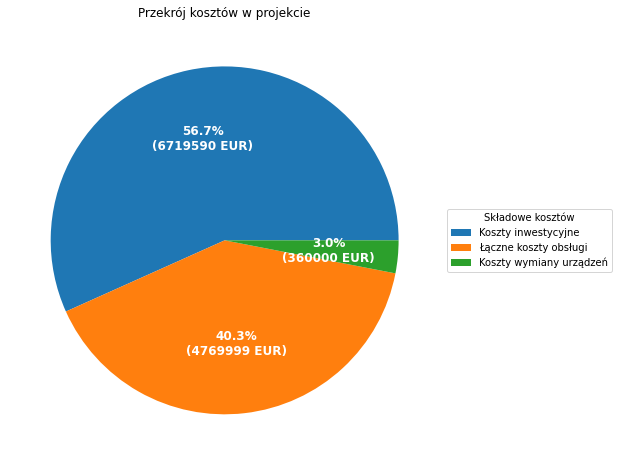


    Wskaźnik NPV wynosi: 2333195.03 EUR
    


In [23]:
economic_analysis(P_n,P_i_nom,P_installed_opt_MW,P_output_MWh_opt)